In [1]:
import torch
import numpy as np
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import random
import torch.nn as nn
np.random.seed(1)
criterion = nn.MSELoss()
os.chdir(os.path.dirname(os.path.abspath("")))
print("current working directory:", os.getcwd())

from utils.dataloaders.full_dataloaders import DataLoaderMNIST, DataLoaderFashionMNIST, DataLoaderCIFAR10, DataLoaderCIFAR100
from utils.visualization import (
    visualize_mapping_error,
    visualize_latent_space_pca,
    plot_latent_space,
    highlight_cluster,
)
from utils.model import load_model, get_transformations
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline

current working directory: /mnt/c/Users/Hillary Hauger/Documents/Studium/SoSe2024/Case Study Non Linear Optimization/Code/latent-communication


In [2]:
def get_stitched_output(model1, model2, mapping, images,device):
    latent_space1 = model1.get_latent_space(images).to(dtype=torch.float32)
    latent_space_stitched = mapping.predict(latent_space1.detach().cpu())
    #Convert to tensor if necessary and to the right dtype
    if isinstance(latent_space_stitched, np.ndarray):
        latent_space_stitched = torch.tensor(latent_space_stitched, dtype=torch.float32)
    elif isinstance(latent_space_stitched, torch.Tensor):
        latent_space_stitched = latent_space_stitched.to(dtype=torch.float32)
    
    outputs = model2.decode(latent_space_stitched.to(device))
    return outputs

def simple_sampler(indices, model, transformations, device, seed=10):
    """
    Input:
    - model: Model
    - indices: Indices of the dataset
    - transformations: Transformations to be applied to the images
    Output:
    - z: Latent vectors of the model
    - labels: Labels of the dataset

    This function samples the latent space of the model and returns the latent vectors
    """
    data_loader = DataLoaderMNIST(128, transformations, seed=seed, indices=indices)
    train_loader = data_loader.get_train_loader()

    # get all images from train_loader and convert them to latent space
    all_images = []
    all_latent_space=[]
    for images, _ in train_loader:
        images = images.to(device)
        latent_space = model.get_latent_space(images)
        all_latent_space.append(latent_space)
        all_images.append(images)
    images = torch.cat(all_images, dim=0)
    z = torch.cat(all_latent_space, dim=0)
    z = z.detach().cpu().numpy()
    labels = data_loader.train_loader.dataset.dataset.targets[indices]
    return z,images,labels

def plot_images_stitched(images,images1,images2,images2_stitched,num_images_to_plot=3):
    indices = random.sample(range(images.shape[0]), num_images_to_plot)
    # Plot the images
    fig, axes = plt.subplots(num_images_to_plot, 4, figsize=(10, 2 * num_images_to_plot))
    for i, idx in enumerate(indices):
        # Original image
        axes[i, 0].imshow(images[idx, 0], cmap='gray')
        axes[i, 0].set_title(f'Original Image {idx}')
        axes[i, 0].axis('off')

        # Images decoded by model 2
        axes[i, 1].imshow(images1[idx, 0].detach().numpy(), cmap='gray')
        axes[i, 1].set_title(f'Model 1 ')
        axes[i, 1].axis('off')


        # Images decoded by model 2
        axes[i, 2].imshow(images2[idx, 0].detach().numpy(), cmap='gray')
        axes[i, 2].set_title(f'Model 2')
        axes[i, 2].axis('off')

        # Stitched image
        axes[i, 3].imshow(images2_stitched[idx, 0].detach().numpy(), cmap='gray')
        axes[i, 3].set_title(f'Stitched ')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

def show_results(mapping,X_train,y_train,X_test,y_test,model1,model2,images,images1,images2,device):
    # Make predictions
    predictions = mapping.predict(X_train)
    print("Predictions error on train set:")
    print(np.linalg.norm(predictions-y_train))
    predictions = mapping.predict(X_test)
    print("Predictions error on test set:")
    print(np.linalg.norm(predictions-y_test))
    print("-------------------------------------------------")
    #Difference between stitched output
    images2_stitched = get_stitched_output(model1,model2,kr,images,device)
    print("MSE between stitched and original model outuput")
    print(criterion(images2_stitched,images).item())
    print("MSE between stitchet and model2 outuput")
    print(criterion(images2_stitched,images2).item())
    print("MSE between stitchet and model1 outuput")
    print(criterion(images2_stitched,images1).item())
    plot_images_stitched(images,images1,images2,images2_stitched,num_images_to_plot=3)

In [3]:
#Load model
name_model = "VerySmall-AE"
name_dataset = "MNIST"
size_of_the_latent = 10
seed1,seed2=1,2
num_samples = 200
model_path1 = f"models/checkpoints/VerySmallAE/{name_dataset}/{name_dataset}_{name_model}_{size_of_the_latent}_{seed1}.pth"
model_path2 = f"models/checkpoints/VerySmallAE/{name_dataset}/{name_dataset}_{name_model}_{size_of_the_latent}_{seed2}.pth"
model1 = load_model(model_name=name_model, name_dataset=name_dataset, latent_size=int(size_of_the_latent), seed=int(seed1), model_path = model_path1)
model2 = load_model(model_name=name_model, name_dataset=name_dataset, latent_size=int(size_of_the_latent), seed=int(seed2), model_path = model_path2)
model1.eval()
model2.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'models/checkpoints/VerySmallAE/MNIST/MNIST_VerySmall-AE_10_1.pth'

In [ ]:
#Load latent space and data
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print("Using device (CPU/GPU):", device)
transformations = get_transformations(name_model)
indices = np.random.randint(0, 10000, num_samples)
latent_space1, images,labels = simple_sampler(indices, model1, transformations, device, seed=10)
latent_space2, images,labels = simple_sampler(indices, model2, transformations, device, seed=10)
images1 = model1(images)
images2 = model2(images)

Using device (CPU/GPU): cpu


In [5]:
#Split data
X= latent_space1
y =latent_space2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
n_train = X_train.shape[0]

Dual coefficients (alpha):
(160, 10)
Predictions error on train set:
40.68175
Predictions error on test set:
45.832027
-------------------------------------------------
MSE between stitched and original model outuput
0.9102535843849182
MSE between stitchet and model2 outuput
0.04167773947119713
MSE between stitchet and model1 outuput
0.0427890382707119


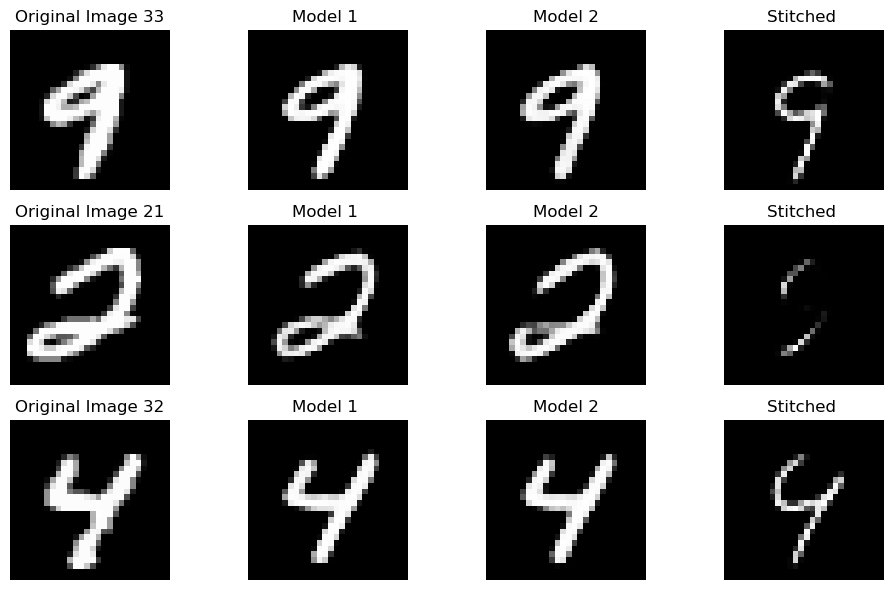

In [6]:
kr = KernelRidge(kernel='rbf', gamma=0.1, alpha=1.0)
kr.fit(X_train,y_train)

print("Dual coefficients (alpha):")
print(kr.dual_coef_.shape)

show_results(kr,X_train,y_train,X_test,y_test,model1,model2,images[n_train:],images1[n_train:],images2[n_train:],device)

Coefficent:
(10, 10)
Predictions error on train set:
21.677916
Predictions error on test set:
14.504475
-------------------------------------------------
MSE between stitched and original model outuput
0.9102535843849182
MSE between stitchet and model2 outuput
0.04167773947119713
MSE between stitchet and model1 outuput
0.0427890382707119


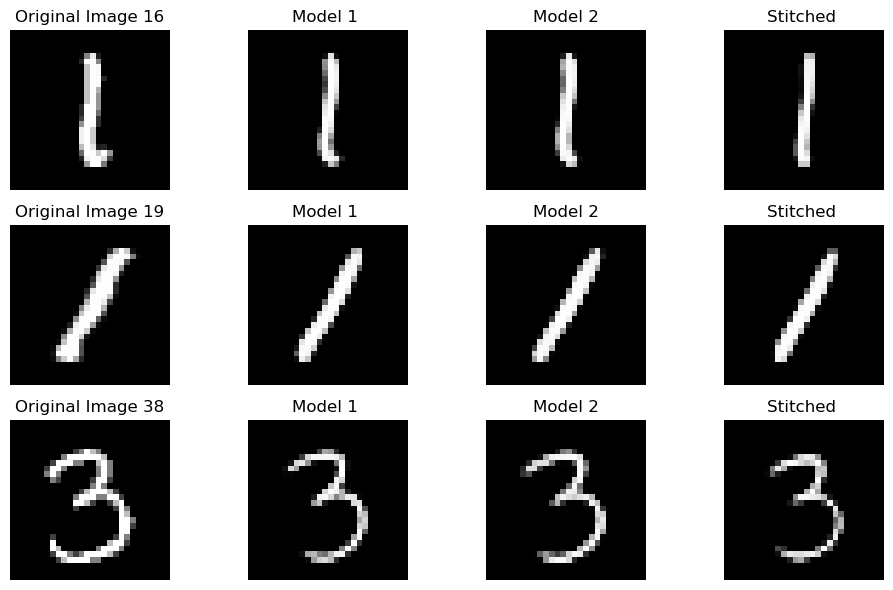

In [7]:
# Create and fit the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

print("Coefficent:")
print(lr.coef_.shape)

show_results(lr,X_train,y_train,X_test,y_test,model1,model2,images[n_train:],images1[n_train:],images2[n_train:],device)

Coefficent:
(10, 10)
Predictions error on train set:
21.678837
Predictions error on test set:
14.469776
-------------------------------------------------
MSE between stitched and original model outuput
0.9102535843849182
MSE between stitchet and model2 outuput
0.04167773947119713
MSE between stitchet and model1 outuput
0.0427890382707119


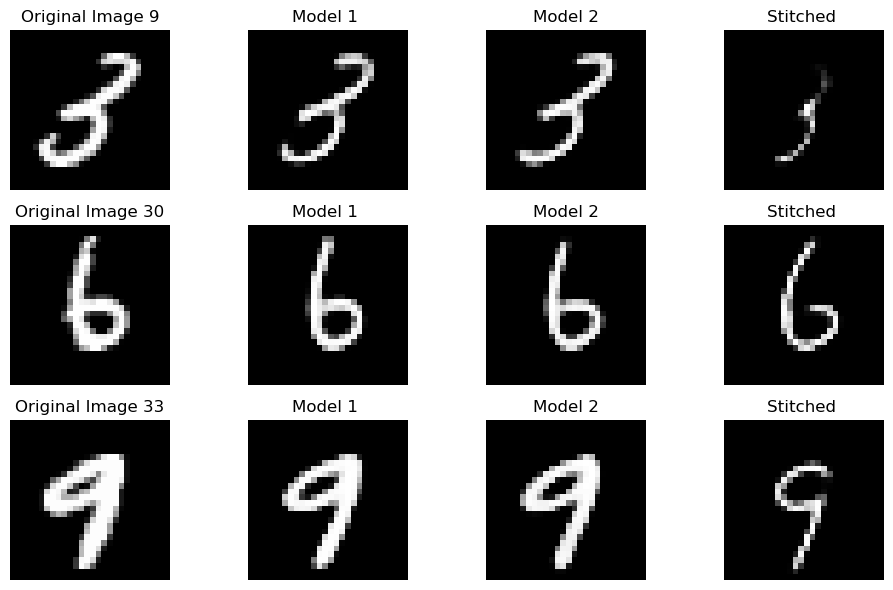

In [8]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

print("Coefficent:")
print(ridge.coef_.shape)

show_results(ridge,X_train,y_train,X_test,y_test,model1,model2,images[n_train:],images1[n_train:],images2[n_train:],device)

Polynomial Regression coefficients:
(10, 285)
Predictions error on train set:
0.0021002227
Predictions error on test set:
34.64933
-------------------------------------------------
MSE between stitched and original model outuput
0.9102535843849182
MSE between stitchet and model2 outuput
0.04167773947119713
MSE between stitchet and model1 outuput
0.0427890382707119


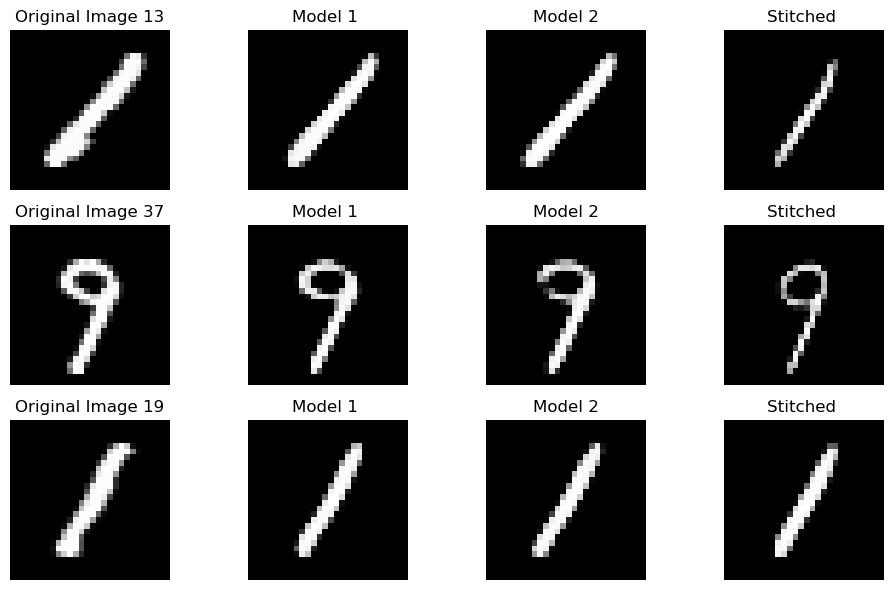

In [9]:
# Polynomial regression setup (degree 2 for example)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# Create and fit the Polynomial Regression model
lr_poly = LinearRegression()
lr_poly.fit(X_poly_train, y_train)

print("Polynomial Regression coefficients:")
print(lr_poly.coef_.shape)

show_results(lr_poly,X_poly_train,y_train,X_poly_test,y_test,model1,model2,images[n_train:],images1[n_train:],images2[n_train:],device)


Spline Regression coefficients shape:
(10, 50)
Predictions error on train set:
16.627415
Predictions error on test set:
16.36574
-------------------------------------------------
MSE between stitched and original model outuput
0.9102535843849182
MSE between stitchet and model2 outuput
0.04167773947119713
MSE between stitchet and model1 outuput
0.0427890382707119


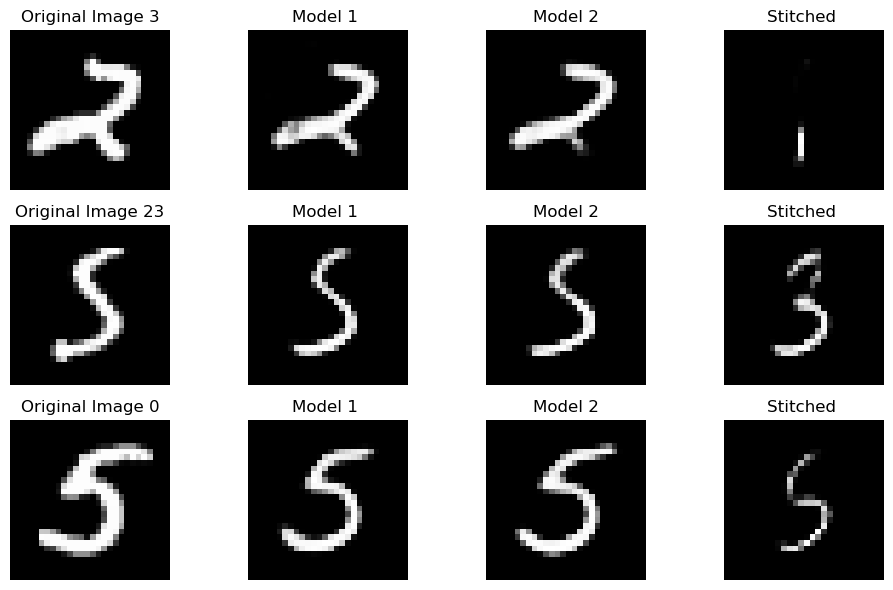

In [10]:
# Create a spline transformer
spline_transformer = SplineTransformer(degree=2, n_knots=5, include_bias=False)

# Create a pipeline with the spline transformer and linear regression
spline_regression = make_pipeline(spline_transformer, LinearRegression())
spline_regression.fit(X_train, y_train)

# Print the shape of the coefficients for Spline Regression
print("\nSpline Regression coefficients shape:")
print(spline_regression.named_steps['linearregression'].coef_.shape)

show_results(spline_regression,X_train,y_train,X_test,y_test,model1,model2,images[n_train:],images1[n_train:],images2[n_train:],device)